# Predicting Item Prices
- This kernel serves as a general exploration into sklearn, seaborn, and nltk. It walks through some exploratory data analysis and visualization, simple NLP feature engineering, and use sklearn and sklearn-pandas to create a ML pipeline and search for optimal hyperparameters.
- This is an exploration of libraries and techinques. I'm more focused on the EDA and modeling workflows than on clever feature engineering and parameter tuning.

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
import numpy as np
import pandas as pd
import pickle
#import lda

from nltk.stem.porter import *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook
#from bokeh.transform import factor_cmap

import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger("lda").setLevel(logging.WARNING)

color = sns.color_palette()

%matplotlib inline
py.init_notebook_mode(connected=True)
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

# Any results you write to the current directory are saved as output.

In [3]:

# PATH = "../input/"
PATH = "./"
train_df = pd.read_csv('{}train.tsv'.format(PATH), sep='\t')
test_df = pd.read_csv('{}test.tsv'.format(PATH), sep='\t')

In [4]:
print(train_df.shape)
print(test_df.shape)

(1482535, 8)
(693359, 7)


In [5]:
train_df.info

<bound method DataFrame.info of          train_id                                     name  item_condition_id  \
0               0      MLB Cincinnati Reds T Shirt Size XL                  3   
1               1         Razer BlackWidow Chroma Keyboard                  3   
2               2                           AVA-VIV Blouse                  1   
3               3                    Leather Horse Statues                  1   
4               4                     24K GOLD plated rose                  1   
5               5         Bundled items requested for Ruie                  3   
6               6       Acacia pacific tides santorini top                  3   
7               7     Girls cheer and tumbling bundle of 7                  3   
8               8                    Girls Nike Pro shorts                  3   
9               9   Porcelain clown doll checker pants VTG                  3   
10             10                          Smashbox primer                  2

**Target Variable Exploration**

In [6]:
train_df.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

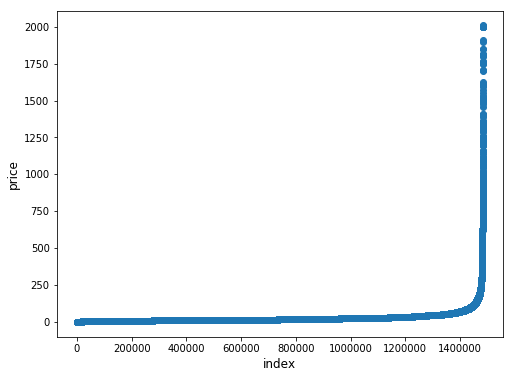

In [7]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

There are some noticable outliers at the tail end, so we might want to remove those.

In [8]:
# ulimit = np.percentile(train_df.price.values, 99)
# llimit = np.percentile(train_df.price.values, 1)
# train_df['price'].ix[train_df['price']>ulimit] = ulimit
# train_df['price'].ix[train_df['price']<llimit] = llimit

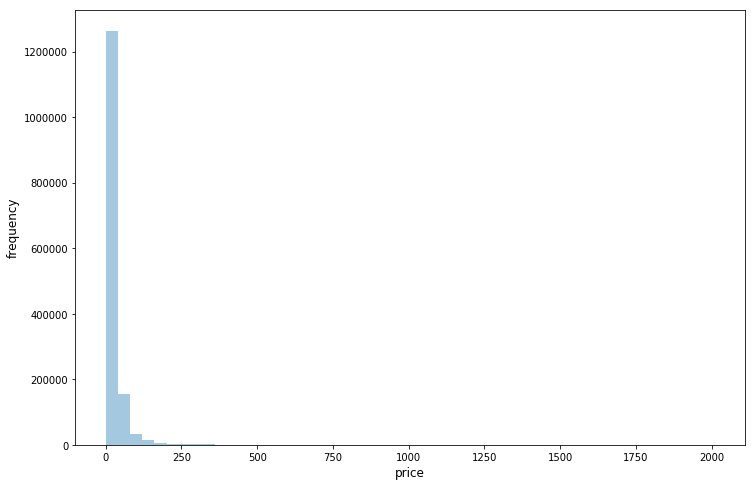

In [9]:
plt.figure(figsize=(12,8))
sns.distplot(train_df.price.values, bins=50, kde=False)
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.show()

Seeing how skewed the distributionWe'll try a log transform.

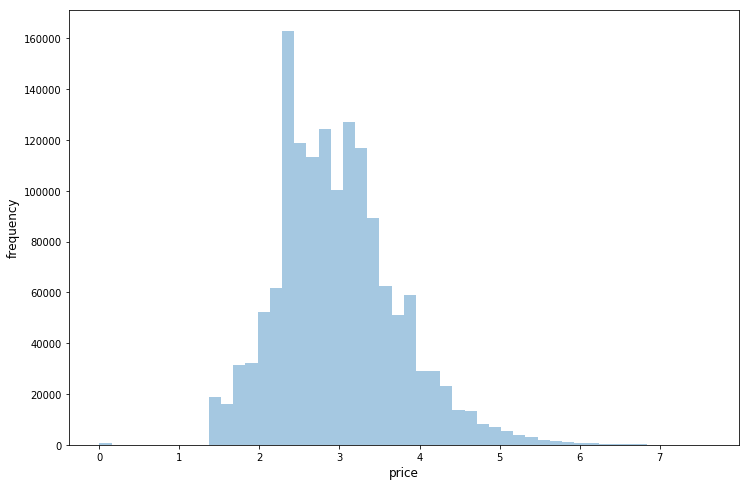

In [10]:
# ulimit = np.percentile(train_df.price.values, 99)
# llimit = np.percentile(train_df.price.values, 1)
# train_df['price'].ix[train_df['price']>ulimit] = ulimit
# train_df['price'].ix[train_df['price']<llimit] = llimit

plt.figure(figsize=(12,8))
sns.distplot(np.log(train_df.price.values + 1), bins=50, kde=False)
plt.ylabel('frequency', fontsize=12)
plt.xlabel('price', fontsize=12)
plt.show()

**Diving into some NLP**

In [11]:
train_df['category_name'].value_counts()[:5]

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
Name: category_name, dtype: int64

In [12]:
# reference: BuryBuryZymon at https://www.kaggle.com/maheshdadhich/i-will-sell-everything-for-free-0-55
def split_cat(text):
    try: return text.split("/")
    except: return ("No Label", "No Label", "No Label")

In [13]:
train_df['general_cat'], train_df['subcat_1'], train_df['subcat_2'] = \
zip(*train_df['category_name'].apply(lambda x: split_cat(x)))
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [14]:
# repeat the same step for the test set
test_df['general_cat'], test_df['subcat_1'], test_df['subcat_2'] = \
zip(*test_df['category_name'].apply(lambda x: split_cat(x)))

In [15]:
print("There are %d unique first sub-categories." % train_df['subcat_1'].nunique())

There are 114 unique first sub-categories.


In [16]:
print("There are %d unique second sub-categories." % train_df['subcat_2'].nunique())

There are 871 unique second sub-categories.


In [17]:
x = train_df['general_cat'].value_counts().index.values.astype('str')
y = train_df['general_cat'].value_counts().values
pct = [("%.2f"%(v*100))+"%"for v in (y/len(train_df))]

In [18]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [19]:
general_cats = train_df['general_cat'].unique()
x = [train_df.loc[train_df['general_cat']==cat, 'price'] for cat in general_cats]

In [20]:
# data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(general_cats))]

In [21]:
# layout = dict(title="Price Distribution by General Category",
#               yaxis = dict(title='Frequency'),
#               xaxis = dict(title='Category'))
# fig = dict(data=data, layout=layout)
# py.iplot(fig)

In [22]:
# train_df.head(25)
train_df_temp = train_df.copy(deep=True)

In [23]:
train_df_temp = train_df_temp.loc[train_df_temp['price'] > 0]
train_df_temp['price'] = train_df_temp['price'].apply(np.log2)
# # train_df_temp = train_df_temp.dropna 
train_df_temp.head(25)
# len(train_df_temp)
# train_df.head(25)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,3.321928,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,5.700440,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,3.321928,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,5.129283,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,5.459432,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces
5,5,Bundled items requested for Ruie,3,Women/Other/Other,NaN,5.882643,0,"Banana republic bottoms, Candies skirt with ma...",Women,Other,Other
6,6,Acacia pacific tides santorini top,3,Women/Swimwear/Two-Piece,Acacia Swimwear,6.000000,0,Size small but straps slightly shortened to fi...,Women,Swimwear,Two-Piece
7,7,Girls cheer and tumbling bundle of 7,3,Sports & Outdoors/Apparel/Girls,Soffe,2.584963,1,You get three pairs of Sophie cheer shorts siz...,Sports & Outdoors,Apparel,Girls
8,8,Girls Nike Pro shorts,3,Sports & Outdoors/Apparel/Girls,Nike,4.247928,0,Girls Size small Plus green. Three shorts total.,Sports & Outdoors,Apparel,Girls
9,9,Porcelain clown doll checker pants VTG,3,Vintage & Collectibles/Collectibles/Doll,NaN,3.000000,0,I realized his pants are on backwards after th...,Vintage & Collectibles,Collectibles,Doll


Nothing immediately jumps out at me from the price description, except that the "Handmade" category seems to be more uniformly distributed. 

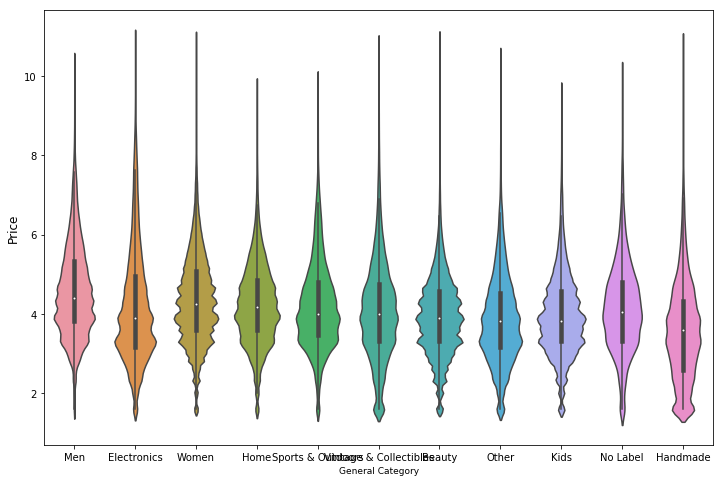

In [24]:
plt.figure(figsize=(12,8))
sns.violinplot(x='general_cat', y='price', data=train_df_temp)
plt.xlabel('General Category', fontsize=9)
plt.ylabel('Price', fontsize=12)
plt.show()

In [25]:
# brand name related features 
def if_brand(row):
    """function to give if brand name is there or not"""
    if row == row:
        return 1
    else:
        return 0
    
train_df['if_brand'] = train_df.brand_name.apply(lambda row : if_brand(row))
test_df['if_brand'] = test_df.brand_name.apply(lambda row : if_brand(row))
train_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,if_brand
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,0
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0


In [26]:
# item description related features 
print("Description of item is not present in {}".format(train_df.loc[train_df.item_description == 'No description yet'].shape[0]))
print("while the shape of train_df is {}".format(train_df.shape[0]))

def if_description(row):
    """function to say if description is present or not"""
    if row == 'No description yet':
        a = 0
    else:
        a = 1
    return a

train_df['is_description'] = train_df.item_description.apply(lambda row : if_description(row))
test_df['is_description'] = test_df.item_description.apply(lambda row : if_description(row))
train_df[['category_name', 'brand_name', 'name', 'price']][train_df['price'] > 0].sort_values('price', ascending=False).head()

Description of item is not present in 82489
while the shape of train_df is 1482535


,category_name,brand_name,name,price
760469,Women/Women's Handbags/Shoulder Bag,Chanel,NEW Chanel WOC Caviar Gold Hardware,2009.0
1262245,Women/Women's Handbags/Messenger & Crossbody,Chanel,NEW-Chanel Boy Wallet o Chain WOC Caviar,2006.0
1393600,Women/Jewelry/Rings,David Yurman,David Yurman Wheaton ring,2004.0
415027,Women/Women's Handbags/Shoulder Bag,Chanel,Chanel Classic Jumbo Single flap bag,2000.0
778940,Beauty/Makeup/Face,Mary Kay,Mary kay,2000.0


A violin plot confirms the somewhat obvious suspicion that price distribution for items with a brand name is skewed slightly higher than those without.

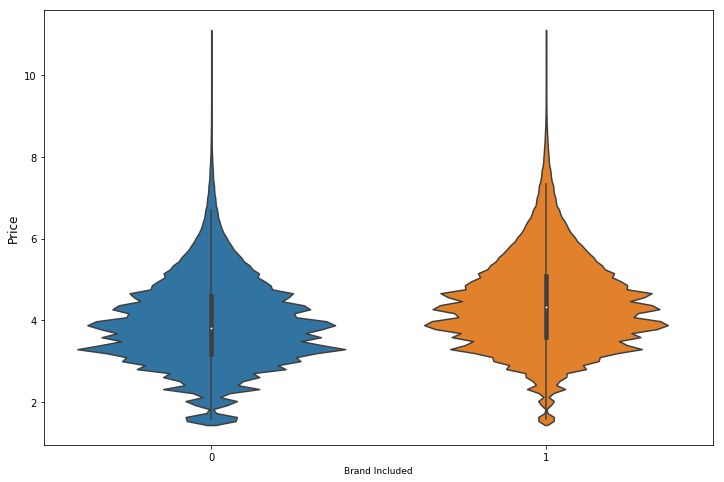

In [27]:
train_df_temp = train_df.copy(deep=True)
train_df_temp = train_df_temp.loc[train_df_temp['price'] > 0]
train_df_temp['price'] = train_df_temp['price'].apply(np.log2)
plt.figure(figsize=(12,8))
sns.violinplot(x='if_brand', y='price', data=train_df_temp)
plt.xlabel('Brand Included', fontsize=9)
plt.ylabel('Price', fontsize=12)
plt.show()

I suspect that the skewness is not equal across top level categories, so let's repeat this process for each of the categories. The features that prove useful in each category may differ to the point where we need to train more than one pricing algorithm based on category.

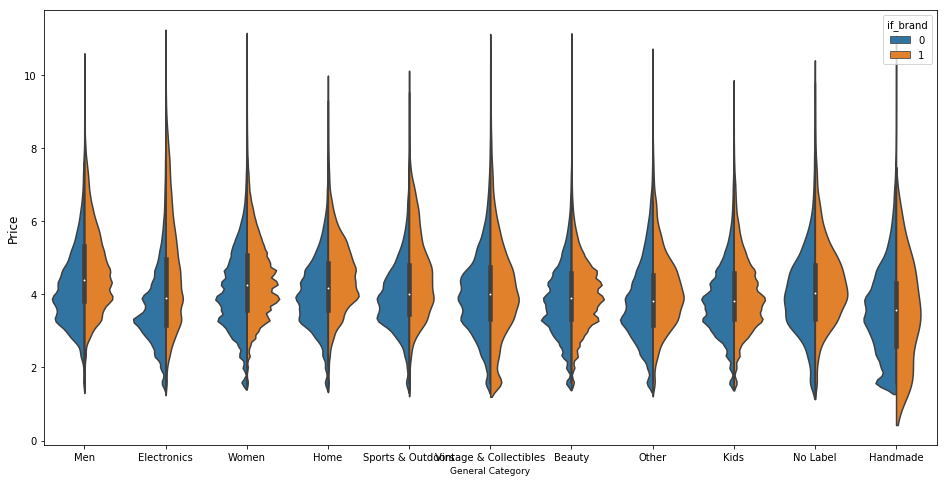

In [28]:
plt.figure(figsize=(16, 8))
sns.violinplot(x='general_cat', y='price', split=True, hue='if_brand', data=train_df_temp)
plt.xlabel('General Category', fontsize=9)
plt.ylabel('Price', fontsize=12)
plt.show()

In [29]:
train_df.sort_values('price', ascending=False)


#features to try: sentiment, tokenize every word in item description and make that a boolean feature 
#RMSLE: write down their metric and use to evaluate models
#try to predict dev from mean of price instead of price itself
#try making it categorical instead of continuous variable
#look into blending / stacking models. meta model

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,if_brand,is_description
760469,760469,NEW Chanel WOC Caviar Gold Hardware,1,Women/Women's Handbags/Shoulder Bag,Chanel,2009.0,0,"New with tag, box and dustbag but no receipt. ...",Women,Women's Handbags,Shoulder Bag,1,1
1262245,1262245,NEW-Chanel Boy Wallet o Chain WOC Caviar,1,Women/Women's Handbags/Messenger & Crossbody,Chanel,2006.0,0,Brand: Chanel Style: WOC Boy Wallet on Chain T...,Women,Women's Handbags,Messenger & Crossbody,1,1
1393600,1393600,David Yurman Wheaton ring,2,Women/Jewelry/Rings,David Yurman,2004.0,0,David Yurman Wheaton wing. Size 6. Original re...,Women,Jewelry,Rings,1,1
742113,742113,Chanel Chevron Fuschia Pink 2,1,Women/Women's Handbags/Shoulder Bag,Chanel,2000.0,1,Authentic Brand new The price for this is [rm]...,Women,Women's Handbags,Shoulder Bag,1,1
956343,956343,Chanel Black wallet on chain,1,Women/Women's Handbags/Messenger & Crossbody,Chanel,2000.0,1,Lambskin Color is Black with dark Silver Hardw...,Women,Women's Handbags,Messenger & Crossbody,1,1
1445348,1445348,Vs2/I 1ct Diamond Engagement Ring,2,Women/Jewelry/Rings,NaN,2000.0,1,Absolutely stunning diamond engagement ring Pu...,Women,Jewelry,Rings,0,1
778940,778940,Mary kay,1,Beauty/Makeup/Face,Mary Kay,2000.0,1,30 time wise sets Oily to combo skin,Beauty,Makeup,Face,1,1
415027,415027,Chanel Classic Jumbo Single flap bag,3,Women/Women's Handbags/Shoulder Bag,Chanel,2000.0,1,Authentic. Pre-loved in Excellent Condition. P...,Women,Women's Handbags,Shoulder Bag,1,1
1250053,1250053,Brand New Chanel CC Quilted WOC,2,Women/Women's Handbags/Messenger & Crossbody,Chanel,2000.0,1,This is a brand new Chanel CC Quilted Wallet o...,Women,Women's Handbags,Messenger & Crossbody,1,1
952000,952000,Chanel J12 H0682 Wrist Watch for Women,3,Women/Women's Accessories/Watches,NaN,1999.0,1,"HELLO , I HAVE A BLACK CHANEL WATCH J12 CERAMI...",Women,Women's Accessories,Watches,0,1


## Workign with Pandas and Sklearn
- sklearn functions expect numpy arrays, not Pandas dataframes
- We'll use sklearn-pandas to be able to unterface with the sklearn package without needing to transform out data

In [30]:
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, LabelBinarizer
from nltk.stem.snowball import EnglishStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import regression
from sklearn.pipeline import FeatureUnion, Pipeline 
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn_pandas import DataFrameMapper, cross_val_score, GridSearchCV
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA, NMF, TruncatedSVD

## Feature Engineering

- Let's start by truncating the data set to 1000 rows so we can quickly iterate and build our ML pipeline

In [31]:
TEST_SIZE = 100000000
train_features_df = train_df.copy(deep=True).head(TEST_SIZE) 
test_features_df = test_df.copy(deep=True).head(TEST_SIZE)

train_features_df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,if_brand,is_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,0,0
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,1,1
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,1,1
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,0,1
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,0,1


In [32]:
wordnet_lemmatizer = WordNetLemmatizer()
analyzer = CountVectorizer().build_analyzer()

def lemmatizer(doc):
    return (wordnet_lemmatizer.lemmatize(w) for w in analyzer(doc))

train_features_df[['category_name', 'item_description']] = train_features_df[['category_name','item_description']].fillna(value="")
test_features_df[['category_name', 'item_description']] = test_features_df[['category_name','item_description']].fillna(value="")

Let's inspect some of the feature names to spot check our lemma transformation. It seems to have worked pretty well.

In [32]:
# # train_count_vect = CountVectorizer(analyzer=lemmatizer, stop_words='english', max_features=10000)
# # test_count_vect = CountVectorizer(analyzer=lemmatizer, stop_words='english', max_features=10000)
# # train_counts = train_count_vect.fit_transform(train_features_df.item_description)
# # test_counts = test_count_vect.fit_transform(test_features_df.item_description)
# # pd.DataFrame(train_counts.todense(), columns=train_count_vect.get_feature_names()).head(1)

# enc = LabelEncoder()
# enc.fit(train_features_df.general_cat)
# train_cat_features = enc.transform(train_features_df['general_cat'])

# enc.fit(test_features_df.general_cat)
# test_cat_features = enc.transform(test_features_df['general_cat'])
# train_features_df['general_cat_label'] = train_cat_features
# test_features_df['general_cat_label'] = test_cat_features

In [33]:
# lb = LabelBinarizer()
# lb.fit_transform(test_features_df.general_cat)
# LabelBinarizer?

In [34]:
# train_features_df['general_cat_label'] = train_features_df['general_cat_label'].apply(lambda x: [x])
# test_features_df['general_cat_label'] = train_features_df['general_cat_label'].apply(lambda x: [x])

In [35]:
# one_hot_encoder = OneHotEncoder(categorical_features='all', handle_unknown='ignore', n_values='auto', sparse=True)
# one_hot_encoder.fit_transform(train_features_df.general_cat_label.reshape(-1, 1))
# one_hot_encoder = OneHotEncoder(categorical_features='all', handle_unknown='ignore', n_values='auto', sparse=True)
# one_hot_encoder.fit_transform(test_features_df.general_cat_label.reshape(-1, 1))

In [36]:
# class CategoryEncoder(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         self.one_hot_encoder = OneHotEncoder(categorical_features='all', handle_unknown='ignore', n_values='auto', sparse=True)
# #         self.column = column

#     def transform(self, df, y=None):
#         return self.one_hot_encoder.fit_transform(df.reshape(-1, 1))

#     def fit(self, df, y=None):
#         return self

## Creating our pipeline
- The `DataFrameMapper` allows us to work with Pandas dataframes in lieu of the numpy arrays that sklearn estimator functions require (it implements the same `fit` and `transform` methods of sklearn estimators and transformers)
- You simply specify the columns and transformations that you've like to apply to them. The option `default=None` means we'll pass unselected columns unchanged. This is useful for columns like `item_condition` which don't need any transformation but we do then have to be careful to only select wanted columns when we fit our pipeline later

In [65]:
# def make_2d(y):
#     return y


# features = feature_mapper.fit_transform(train_features_df[train_features_df.columns.drop('price')])
# scores = cross_val_score(rfr_model, X=features, y=train_features_df['price'], scoring='r2')
# print(scores)

# linear_pipeline  = Pipeline([('mapper', feature_mapper),('clf', SGDClassifier(n_iter=15, warm_start=True))])
# train_features_df.shape
# PCA?
# TruncatedSVD?

In [33]:
to_vect = Pipeline([('vect', CountVectorizer(analyzer=lemmatizer, stop_words='english', max_features=1000)),
                    ('tfidf', TfidfTransformer()),
                    ('pca', TruncatedSVD(n_components=5))])

FEATURES = ['name', 'item_description', 'general_cat', 'subcat_1', 'subcat_2', 'shipping', 'if_brand', 'is_description', 'item_condition_id']

feature_mapper = DataFrameMapper([
    ('item_description', to_vect),
    ('name', to_vect),
    ('general_cat', LabelBinarizer()),
    ('subcat_1', LabelBinarizer()),
    ('subcat_2', LabelBinarizer())
    ], sparse=False, default=None) 

rfr = RandomForestRegressor(
    n_jobs=-1,
    random_state=True,
    oob_score = True) 

rfr_pipeline = Pipeline([('featurize', feature_mapper), ('rfr', rfr)])
# linear_rgr_pipeline = Pipeline([('featurize', feature_mapper), ('forest', LinearRegression())])

In [45]:
#SOME CODE I SHOULD DELETE AT SOME POINT
# from sklearn.model_selection import train_test_split
# # X_train, X_test, y_train, y_test = train_test_split(
# #     train_features_df[FEATURES], train_features_df['price'], test_size=0.3
# # )
# train_df_temp = train_features_df[FEATURES].copy(deep=True)
# cross_val_score(rfr_pipeline, train_df_temp, y=train_features_df.price)

In [34]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

## Hyperparameter Tuning
- We'll set up a grid search to find good hyperparameters for for random forest regressor
- Since we're passing a pipeline as the estimator to `RandomizedSearchCV` we have to prefix our regressor paramators with the step name (i.e. rfr__)

In [ ]:
from time import time
from scipy.stats import randint as sp_randint

param_ditributions = {"rfr__n_estimators": sp_randint(50, 500),
                  "rfr__max_depth": sp_randint(2, 10),
                  "rfr__max_features": ['sqrt'],
                  "rfr__min_samples_split": [0.02, 0.05, 0.1],
                  "rfr__min_samples_leaf": [0.05, 0.2, 0.3]}

# run randomized search
n_iter_search = 5
random_search = RandomizedSearchCV(rfr_pipeline, param_distributions=param_ditributions,
                                   n_iter=n_iter_search)
random_search.fit(train_features_df[FEATURES], train_features_df.price)
report(random_search.cv_results_)

## Inspecting the random forest model
- We've used a grid search to tune our random forest model. Now let's train the model on just those paramaters so that we can visualize the results

In [ ]:
rfr_params = {}
for key, val in random_search.best_params_.items():
    rfr_params[key[len("rfr__"):]] = val
random_search.best_params_
rfr = RandomForestRegressor(
    **rfr_params,
    n_jobs=-1,
    random_state=True,
    oob_score = True) 
rfr_pipeline = Pipeline([('featurize', feature_mapper), ('rfr', rfr)])
rfr_pipeline.fit(train_features_df[FEATURES], train_features_df.price)

In [ ]:
# feature_importances = zip(rfr_pipeline.named_steps['rfr'].feature_importances_)
# # sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
# for f in feature_importances:
#     print(f)
# feature_importances = zip(features, model.feature_importances_)

In [ ]:
importances = rfr_pipeline.named_steps['rfr'].feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr_pipeline.named_steps['rfr'].estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(train_features_df.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(train_features_df.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.xticks(range(train_features_df.shape[1]), indices)
# plt.xlim([-1, train_features_df.shape[1]])
# plt.show()


In [74]:
rfr_param_grid = {"rfr__n_estimators": [500, 1000, 2000],
                  "rfr__max_depth": [3, None],
                  "rfr__max_features": ['auto', 'sqrt'],
                  "rfr__min_samples_split": [2, 3, 10],
                  "rfr__min_samples_leaf": [0.05, 0.2, 0.3]}

grid_search = GridSearchCV(estimator=rfr_pipeline, param_grid=rfr_param_grid, refit=False)
start = time()
grid_search.fit(train_features_df, train_features_df.price)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

KeyboardInterrupt: 

In [67]:


# feature_importances = zip(rfr_pipeline.named_steps['forest'].feature_importances_)
# # sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)
# for f in feature_importances:
#     print(f)
# # feature_importances = zip(features, model.feature_importances_)

Model with rank: 1
Mean validation score: -0.784 (std: 0.906)
Parameters: {'rfr__n_estimators': 2}

Model with rank: 2
Mean validation score: -2.233 (std: 2.614)
Parameters: {'rfr__n_estimators': 1}

